## Master Notebook - Update

The goal of this notebook is to improve the model in the previous version of the notebook.  The presentation and readme were created in reference to the previous model.  This version simply shows improvements we can make to the model when given additional time.

## Steps

* Import Training Data
* Check Assumptions of Linear Regression
* Create New Metrics
* Iterate Through Regression Models (Choose Best in Terms of R-Squared)
* Let The User Input Hypothetical Home Data to Predict the Price of Their Home

## Import Training Data

In [1]:
#Pull in Data
import pandas as pd
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/Users/jamesfay/Desktop/FlatironWorkingDirectory/mod_2_project_v2/Data/Train_Table.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,id,bedrooms,bathrooms,sqft_living,log_lot,sqft_lot,floors,waterfront,condition,grade,zipcode,lat,long,yr_of_last_update,season_sold,below_ground_ratio,price_100k,long_lat,district,is_seattle
0,7504400290,5,2.50,3470,9.392912,12003,2.0,0.0,3,8,98074,47.6240,-122.048,1978,Spring,0.000000,5.990,"(-122.04799999999999, 47.623999999999995)",Lake Washington,0.0
1,6403500570,5,2.75,2990,8.911934,7420,2.0,0.0,3,8,98059,47.4944,-122.162,1996,Summer,0.000000,4.985,"(-122.162, 47.4944)",Renton,0.0
2,7934000145,4,2.75,2900,8.764053,6400,2.0,0.0,3,7,98136,47.5563,-122.393,1970,Winter,0.421569,4.500,"(-122.39299999999999, 47.5563)",Seattle,1.0
3,203100625,3,2.50,2620,9.979847,21587,2.0,0.0,3,7,98053,47.6384,-121.959,1992,Spring,0.000000,6.720,"(-121.959, 47.6384)",Snoqualmie Valley,0.0
4,2211700160,3,1.50,1770,9.753130,17208,1.0,0.0,3,8,98006,47.5659,-122.117,1959,Spring,0.525862,4.500,"(-122.117, 47.5659)",Issaquah,0.0


In [2]:
df.shape

(17094, 20)

## Check Linearity Assumption

In [3]:
def linearity_test(df):
    y = df['log_price']
    fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,15))
    for n in range(len(df.columns) - 1):
        row = (n-1)//4
        col = n%4-1
        ax = axes[row][col]
        column = df.columns[n]
        x = df[column]
        ax.scatter(x,y)
        ax.set_title(str(column) + ' vs Price')

In [4]:
#Create df with only variables we could use in regression.  Create log_lot variable
reg_df = df.drop(['zipcode', 'lat', 'long', 'id', 'long_lat', 'sqft_lot'], axis=1)

Grade, Bathrooms, and Sqft_living seem to have linear relationships with price.  Other variables have less linear relationships, so adjustments may have to be made

## Plot Histograms

In [5]:
def plot_histograms(df):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,15))
    for n in range(len(df.columns) - 1):
        row = (n-1)//3
        col = n%3-1
        ax = axes[row][col]
        column = df.columns[n]
        x = df[column]
        ax.hist(x)
        ax.set_title(str(column))
        

Normally distributed variables are not a requirement of Linear Regression, but this helps us understand our data better.

## Check For Multicollinearity

In [6]:
def check_multicollinearity(df, independent_var_name, cutoff):
    copy_df = df.drop(independent_var_name, axis=1)
    # copy_df = reg_df

    # save absolute value of correlation matrix as a data frame
    # converts all values to absolute value
    # stacks the row:column pairs into a multindex
    # reset the index to set the multindex to seperate columns
    # sort values. 0 is the column automatically generated by the stacking

    pair_df=copy_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    pair_df['pairs'] = list(zip(pair_df.level_0, pair_df.level_1))

    # set index to pairs
    pair_df.set_index(['pairs'], inplace = True)

    #drop level columns
    pair_df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column
    pair_df.columns = ['correlation_coefficient']

    # drop duplicates. 
    pair_df.drop_duplicates(inplace=True)
    return pair_df[(pair_df.correlation_coefficient>cutoff) & (pair_df.correlation_coefficient <1)]

In [7]:
check_multicollinearity(reg_df, 'price_100k', 0.6)

,correlation_coefficient
pairs,
"(grade, sqft_living)",0.750909
"(bathrooms, sqft_living)",0.742246
"(grade, bathrooms)",0.650483


Grade, sqft_living, and bathrooms are correlated with eachother, so interpreting the coefficients of these variables will be inaccurate.

## Create New Metrics

**Create top_5_district**

This code converts district names into a single binary column.  This new column shows a '1' if the house is in one of the top 5 King County public school districts, and a '0' otherwise.  This metric is more interpretable than having 20 different categorical variables for district (one for each district).

In [8]:
# https://backgroundchecks.org/top-school-districts-in-washington-2018.html
# Rankings based on student performance (math and reading test scores), dropout rates, school funding, and area poverty rates
top_5_str = 'Mercer Island|Lake Washington|Snoqualmie Valley|Bellevue|Issaquah'
reg_df.loc[reg_df['district'].str.contains(top_5_str),'top_5_district'] = 1
reg_df['top_5_district'].fillna(0, inplace=True)
reg_df.head()

,bedrooms,bathrooms,sqft_living,log_lot,floors,waterfront,condition,grade,yr_of_last_update,season_sold,below_ground_ratio,price_100k,district,is_seattle,top_5_district
0,5,2.50,3470,9.392912,2.0,0.0,3,8,1978,Spring,0.000000,5.990,Lake Washington,0.0,1.0
1,5,2.75,2990,8.911934,2.0,0.0,3,8,1996,Summer,0.000000,4.985,Renton,0.0,0.0
2,4,2.75,2900,8.764053,2.0,0.0,3,7,1970,Winter,0.421569,4.500,Seattle,1.0,0.0
3,3,2.50,2620,9.979847,2.0,0.0,3,7,1992,Spring,0.000000,6.720,Snoqualmie Valley,0.0,1.0
4,3,1.50,1770,9.753130,1.0,0.0,3,8,1959,Spring,0.525862,4.500,Issaquah,0.0,1.0


In [9]:
#Drop old district variable
reg_df.drop(['district'], axis=1, inplace=True)

**Get Season Dummy Variables**

This shows the effect that season has on the price of a home, relative to the price of homes sold in the Fall.

In [10]:
#Dummy var for season_sold, with Summer as the reference variable
seasons = pd.get_dummies(reg_df['season_sold'], drop_first=True)
reg_df = pd.concat([reg_df, seasons], axis=1)
# reg_df.drop(['Summer'], axis=1, inplace=True)

In [11]:
reg_df = reg_df.drop(['season_sold'], axis=1)
reg_df.head()

,bedrooms,bathrooms,sqft_living,log_lot,floors,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter
0,5,2.50,3470,9.392912,2.0,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0
1,5,2.75,2990,8.911934,2.0,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0
2,4,2.75,2900,8.764053,2.0,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1
3,3,2.50,2620,9.979847,2.0,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0
4,3,1.50,1770,9.753130,1.0,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0


## Iterate Through Regression Models

For the sake of brevity, early models are not included here.  Early models treated Floors, Grade, and Condition as continuous variables, but R-Squared was improved by treating them as categorical variables.

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

**Check Residual Homoscedasticity**

In [13]:
# Check Homoskedasticity
def gq_test(data, model):
    
    #Graph heteroskedasticity
    pred_val = model.fittedvalues.copy()
#     true_val = data['price_100k'].values.copy()
    residual = model.resid
    
    fig, ax = plt.subplots()
    graph = ax.scatter(pred_val, residual)
    
    # Run Goldfeld Quandt test
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(model.resid, model.model.exog)
    return list(zip(name, test))


## Regression v1

**Turn Continuous Variables into Categorical Variables**

In [14]:
#Floors
reg_df2 = reg_df
floors = pd.get_dummies(reg_df2['floors'], prefix='floors', drop_first=True)
reg_df2 = pd.concat([reg_df2, floors], axis=1)
reg_df2.drop('floors', axis=1, inplace=True)

#Rename floors so no decimal in column name
reg_df2.rename(columns={'floors_1.5':'floors_1h','floors_2.0':'floors_2','floors_2.5':'floors_2h','floors_3.0':'floors_3','floors_3.5':'floors_3h'}, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter,floors_1h,floors_2,floors_2h,floors_3,floors_3h
0,5,2.50,3470,9.392912,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0,0,1,0,0,0
1,5,2.75,2990,8.911934,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0,0,1,0,0,0
2,4,2.75,2900,8.764053,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1,0,1,0,0,0
3,3,2.50,2620,9.979847,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0,0,1,0,0,0
4,3,1.50,1770,9.753130,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0,0,0,0,0,0


In [15]:
#Grade - Data in master table ranges from 3-13
grade = pd.get_dummies(reg_df2['grade'], prefix='grade', drop_first=True)
reg_df2 = pd.concat([reg_df2, grade], axis=1)
reg_df2.drop('grade', axis=1, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,5,2.50,3470,9.392912,0.0,3,1978,0.000000,5.990,0.0,...,0,0,0,0,1,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,1996,0.000000,4.985,0.0,...,0,0,0,0,1,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,1970,0.421569,4.500,1.0,...,0,0,0,1,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,1992,0.000000,6.720,0.0,...,0,0,0,1,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,1959,0.525862,4.500,0.0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
#Condition 
condition = pd.get_dummies(reg_df2['condition'], prefix='cond', drop_first=True)
reg_df2 = pd.concat([reg_df2, condition], axis=1)
reg_df2.drop('condition', axis=1, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_2,cond_3,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,5.990,0.0,1.0,...,1,0,0,0,0,0,0,1,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,4.985,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,4.500,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,3,2.50,2620,9.979847,0.0,1992,0.000000,6.720,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,3,1.50,1770,9.753130,0.0,1959,0.525862,4.500,0.0,1.0,...,1,0,0,0,0,0,0,1,0,0


In [17]:
outcome = 'price_100k'
predictors = reg_df2.drop('price_100k', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1433.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:20:14   Log-Likelihood:                -31441.
No. Observations:               17094   AIC:                         6.295e+04
Df Residuals:                   17062   BIC:                         6.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.1604      2.044     13.289      0.000      23.154      31.166
bedrooms              -0.1211      0.017     -6.992      0.000      -0.155      -0.087
bathrooms              0.2793      0.028      9.859      0.000       0.224       0.335
sqft_living            0.0014    3.1e-05     43.849      0.000       0.001       0.001
log_lot                0.0482      0.017      2.754      0.006       0.014       0.082
waterfront             4.8166      0.169     28.543      0.000       4.486       5.147
yr_of_last_update     -0.0139      0.001    -20.671      0.000      -0.015      -0.013
below_ground_ratio    -0.3800      0.053     -7.231      0.000      -0.483      -0.277
is_seattle             2.1047      0.037     57.569      0.000       2.033       2.176
top_5_district         1.8094      0.030     59.695      0.000       1.750       1.869
Spring                 0.2767      0.032      8.607      0.000       0.214       0.340
Summer                 0.0262      0.032      0.810      0.418      -0.037       0.090
Winter                 0.0703      0.037      1.895      0.058      -0.002       0.143
floors_1h             -0.0031      0.047     -0.067      0.947      -0.095       0.089
floors_2              -0.2617      0.039     -6.637      0.000      -0.339      -0.184
floors_2h              0.2624      0.150      1.750      0.080      -0.031       0.556
floors_3              -0.0305      0.087     -0.352      0.725      -0.201       0.140
floors_3h             -0.1524      0.882     -0.173      0.863      -1.881       1.576
grade_4               -0.5704      1.565     -0.365      0.715      -3.637       2.497
grade_5               -0.6333      1.529     -0.414      0.679      -3.630       2.364
grade_6               -0.5888      1.526     -0.386      0.700      -3.579       2.401
grade_7                0.0190      1.526      0.012      0.990      -2.971       3.009
grade_8                0.8375      1.526      0.549      0.583      -2.154       3.829
grade_9                2.0868      1.527      1.367      0.172      -0.906       5.079
grade_10               3.3062      1.528      2.164      0.030       0.312       6.301
grade_11               4.6901      1.531      3.064      0.002       1.690       7.690
grade_12               7.0178      1.544      4.544      0.000       3.991      10.045
grade_13               9.2811      2.159      4.299      0.000       5.049      13.513
cond_2                -0.0801      0.346     -0.231      0.817      -0.759       0.599
cond_3                 0.2067      0.321      0.645      0.519      -0.422       0.835
cond_4                 0.4852      0.321      1.513      0.130      -0.143       1.114
cond_5                 0.8998      0.323      2.790      0.005       0.268       1.532
======================================

**Check Normality of Residuals**

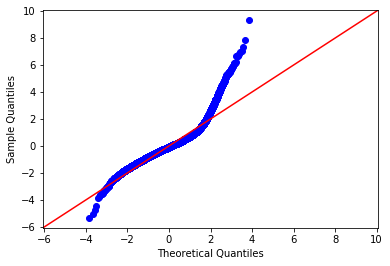

In [18]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

This indicates serious issues with normality.  The assumption of normal residuals is not met.

**Check Heteroscedasticity**

[('F statistic', 1.036604823912329), ('p-value', 0.04858643950891584)]

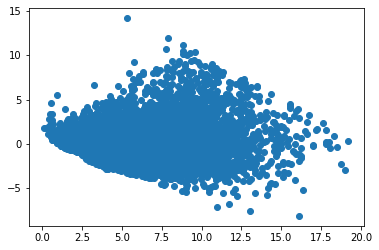

In [19]:
gq_test(reg_df2, model)

This is not a worst-case scenario, but a visual inspection shows that there is some heteroscedasticity.

## Regression v2

Here the reference variables in the regression's categorical variables were adjusted to more accurately reflect the 'average' house.

In [20]:
#Floors
reg_df3 = reg_df
floors = pd.get_dummies(reg_df3['floors'], prefix='floors')
reg_df3 = pd.concat([reg_df3, floors], axis=1)
reg_df3.drop('floors', axis=1, inplace=True)

#Drop floor 2 to make it ref var
reg_df3.drop('floors_2.0', axis=1, inplace=True)

#Rename floors so no decimal in column name
reg_df3.rename(columns={'floors_1.0':'floors_1', 'floors_1.5':'floors_1h','floors_2.0':'floors_2','floors_2.5':'floors_2h','floors_3.0':'floors_3','floors_3.5':'floors_3h'}, inplace=True)

reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter,floors_1,floors_1h,floors_2h,floors_3,floors_3h
0,5,2.50,3470,9.392912,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0,1,0,0,0,0


In [21]:
#Grade - Data in master table ranges from 3-13
grade = pd.get_dummies(reg_df3['grade'], prefix='grade')
reg_df3 = pd.concat([reg_df3, grade], axis=1)

#Drop Grade 7 (average grade) to make ref var
reg_df3.drop('grade_7', axis=1, inplace=True)

reg_df3.drop('grade', axis=1, inplace=True)
reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,...,grade_3,grade_4,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,5,2.50,3470,9.392912,0.0,3,1978,0.000000,5.990,0.0,...,0,0,0,0,1,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,1996,0.000000,4.985,0.0,...,0,0,0,0,1,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,1970,0.421569,4.500,1.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,1992,0.000000,6.720,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,1959,0.525862,4.500,0.0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
#Condition 
condition = pd.get_dummies(reg_df3['condition'], prefix='cond')
reg_df3 = pd.concat([reg_df3, condition], axis=1)

#Drop Condition 3 (average cond) to make ref var
reg_df3.drop('cond_3', axis=1, inplace=True)

reg_df3.drop('condition', axis=1, inplace=True)
reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,5.990,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,4.985,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,4.500,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,1992,0.000000,6.720,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,1959,0.525862,4.500,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0


In [23]:
outcome = 'price_100k'
predictors = reg_df3.drop('price_100k', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1433.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:20:18   Log-Likelihood:                -31441.
No. Observations:               17094   AIC:                         6.295e+04
Df Residuals:                   17062   BIC:                         6.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.1244      1.362     19.916      0.000      24.455      29.794
bedrooms              -0.1211      0.017     -6.992      0.000      -0.155      -0.087
bathrooms              0.2793      0.028      9.859      0.000       0.224       0.335
sqft_living            0.0014    3.1e-05     43.849      0.000       0.001       0.001
log_lot                0.0482      0.017      2.754      0.006       0.014       0.082
waterfront             4.8166      0.169     28.543      0.000       4.486       5.147
yr_of_last_update     -0.0139      0.001    -20.671      0.000      -0.015      -0.013
below_ground_ratio    -0.3800      0.053     -7.231      0.000      -0.483      -0.277
is_seattle             2.1047      0.037     57.569      0.000       2.033       2.176
top_5_district         1.8094      0.030     59.695      0.000       1.750       1.869
Spring                 0.2767      0.032      8.607      0.000       0.214       0.340
Summer                 0.0262      0.032      0.810      0.418      -0.037       0.090
Winter                 0.0703      0.037      1.895      0.058      -0.002       0.143
floors_1               0.2617      0.039      6.637      0.000       0.184       0.339
floors_1h              0.2586      0.054      4.822      0.000       0.153       0.364
floors_2h              0.5242      0.147      3.575      0.000       0.237       0.812
floors_3               0.2312      0.078      2.966      0.003       0.078       0.384
floors_3h              0.1093      0.881      0.124      0.901      -1.617       1.836
grade_3               -0.0190      1.526     -0.012      0.990      -3.009       2.971
grade_4               -0.5894      0.352     -1.673      0.094      -1.280       0.101
grade_5               -0.6524      0.115     -5.693      0.000      -0.877      -0.428
grade_6               -0.6079      0.045    -13.593      0.000      -0.696      -0.520
grade_8                0.8185      0.032     25.328      0.000       0.755       0.882
grade_9                2.0677      0.049     41.935      0.000       1.971       2.164
grade_10               3.2872      0.071     46.314      0.000       3.148       3.426
grade_11               4.6711      0.117     40.093      0.000       4.443       4.899
grade_12               6.9987      0.235     29.725      0.000       6.537       7.460
grade_13               9.2620      1.527      6.067      0.000       6.270      12.254
cond_1                -0.2067      0.321     -0.645      0.519      -0.835       0.422
cond_2                -0.2868      0.138     -2.084      0.037      -0.557      -0.017
cond_4                 0.2784      0.030      9.397      0.000       0.220       0.337
cond_5                 0.6931      0.048     14.566      0.000       0.600       0.786
======================================

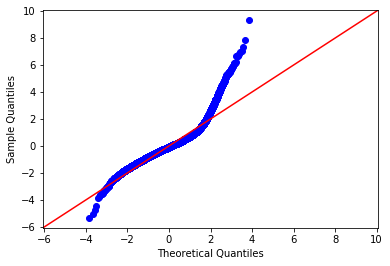

In [24]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

[('F statistic', 1.0366048239123289), ('p-value', 0.04858643950896008)]

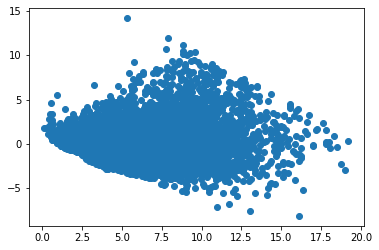

In [25]:
gq_test(reg_df3, model)

## Fix Assumptions

Normalize residuals, get rid of heteroscedasticity

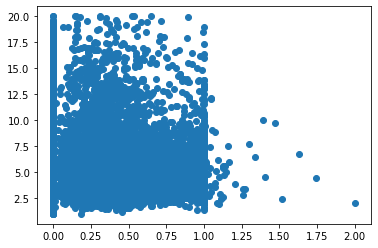

In [26]:
plt.scatter(reg_df3['below_ground_ratio'], reg_df3['price_100k'])

In [27]:
#Drop non-linear
reg_df4 = reg_df3.copy()
check_multicollinearity(reg_df4, 'price_100k', 0.5)

,correlation_coefficient
pairs,
"(bathrooms, sqft_living)",0.742246
"(bedrooms, sqft_living)",0.591297
"(bathrooms, yr_of_last_update)",0.546739
"(bathrooms, bedrooms)",0.517665


In [28]:
reg_df4['log_price'] = np.log(reg_df4['price_100k'])
reg_df4.drop('price_100k', axis=1, inplace=True)

In [29]:
reg_df4.drop(['yr_of_last_update', 'below_ground_ratio'], axis=1)

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,is_seattle,top_5_district,Spring,Summer,Winter,...,grade_9,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5,log_price
0,5,2.50,3470,9.392912,0.0,0.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.790091
1,5,2.75,2990,8.911934,0.0,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.606433
2,4,2.75,2900,8.764053,0.0,1.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.504077
3,3,2.50,2620,9.979847,0.0,0.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.905088
4,3,1.50,1770,9.753130,0.0,0.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.504077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17089,1,1.00,700,8.536996,0.0,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.252763
17090,3,1.00,1150,8.999619,0.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.615186
17091,3,1.75,1790,10.830303,0.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,1.249902
17092,3,3.50,1690,7.266827,0.0,1.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.607436


In [30]:
check_multicollinearity(reg_df4, 'log_price', 0.6)

,correlation_coefficient
pairs,
"(bathrooms, sqft_living)",0.742246


In [31]:
reg_df4.drop(['bathrooms', 'below_ground_ratio'], axis=1, inplace=True)

In [32]:
reg_df4.head()

,bedrooms,sqft_living,log_lot,waterfront,yr_of_last_update,is_seattle,top_5_district,Spring,Summer,Winter,...,grade_9,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5,log_price
0,5,3470,9.392912,0.0,1978,0.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.790091
1,5,2990,8.911934,0.0,1996,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.606433
2,4,2900,8.764053,0.0,1970,1.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.504077
3,3,2620,9.979847,0.0,1992,0.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.905088
4,3,1770,9.753130,0.0,1959,0.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.504077


In [33]:
outcome = 'log_price'
predictors = reg_df4.drop('log_price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df4).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     1734.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:20:21   Log-Likelihood:                -648.94
No. Observations:               17094   AIC:                             1358.
Df Residuals:                   17064   BIC:                             1590.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2293      0.218     19.443      0.000       3.803       4.656
bedrooms             -0.0134      0.003     -4.769      0.000      -0.019      -0.008
sqft_living           0.0002   4.34e-06     54.150      0.000       0.000       0.000
log_lot               0.0332      0.003     11.704      0.000       0.028       0.039
waterfront            0.5904      0.028     21.212      0.000       0.536       0.645
yr_of_last_update    -0.0019      0.000    -18.230      0.000      -0.002      -0.002
is_seattle            0.4563      0.006     77.494      0.000       0.445       0.468
top_5_district        0.3962      0.005     79.184      0.000       0.386       0.406
Spring                0.0505      0.005      9.524      0.000       0.040       0.061
Summer                0.0029      0.005      0.536      0.592      -0.008       0.013
Winter                0.0053      0.006      0.870      0.384      -0.007       0.017
floors_1             -0.0168      0.006     -3.009      0.003      -0.028      -0.006
floors_1h             0.0249      0.009      2.856      0.004       0.008       0.042
floors_2h             0.0411      0.024      1.700      0.089      -0.006       0.089
floors_3              0.0307      0.013      2.391      0.017       0.006       0.056
floors_3h             0.0879      0.145      0.604      0.546      -0.197       0.373
grade_3              -0.0625      0.252     -0.248      0.804      -0.556       0.431
grade_4              -0.3630      0.058     -6.244      0.000      -0.477      -0.249
grade_5              -0.2986      0.019    -15.789      0.000      -0.336      -0.261
grade_6              -0.2163      0.007    -29.414      0.000      -0.231      -0.202
grade_8               0.1940      0.005     36.537      0.000       0.184       0.204
grade_9               0.3585      0.008     44.546      0.000       0.343       0.374
grade_10              0.4380      0.012     37.989      0.000       0.415       0.461
grade_11              0.4778      0.019     25.288      0.000       0.441       0.515
grade_12              0.5795      0.039     15.030      0.000       0.504       0.655
grade_13              0.7385      0.252      2.931      0.003       0.245       1.232
cond_1               -0.0916      0.053     -1.731      0.083      -0.195       0.012
cond_2               -0.1372      0.023     -6.037      0.000      -0.182      -0.093
cond_4                0.0429      0.005      8.786      0.000       0.033       0.052
cond_5                0.1172      0.008     15.028      0.000       0.102       0.132
==============================================================================
Omnibus:                      209.079   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              373.986
Skew:   

In [34]:
# !pip install mpld3

In [35]:
# %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()

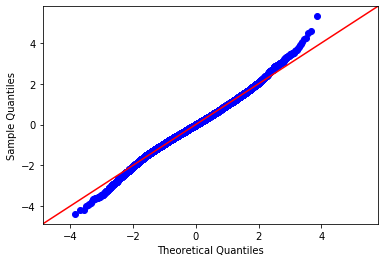

In [36]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

[('F statistic', 1.0208612576318938), ('p-value', 0.170362138808579)]

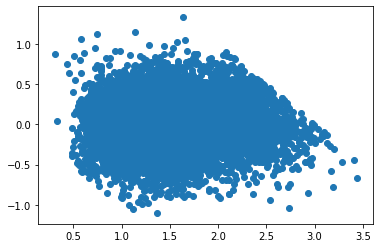

In [37]:
gq_test(reg_df4, model)

Much better, but not perfect

## Fix Issues

In [38]:
reg_df5 = reg_df4.copy()

In [39]:
check_multicollinearity(reg_df5, 'log_price', 0.5)

,correlation_coefficient
pairs,
"(sqft_living, bedrooms)",0.591297


In [40]:
#Adjust so sqft has linear relationship with log_price
reg_df5['log_living'] = np.log(reg_df5['sqft_living'])

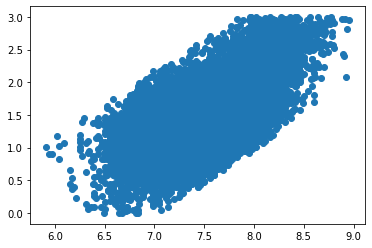

In [41]:
plt.scatter(reg_df5['log_living'], reg_df5['log_price'])

In [42]:
#Drop bedrooms to solve multicollinearity
reg_df5.drop(['bedrooms', 'sqft_living'], axis=1, inplace=True)
reg_df5.head()

,log_lot,waterfront,yr_of_last_update,is_seattle,top_5_district,Spring,Summer,Winter,floors_1,floors_1h,...,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5,log_price,log_living
0,9.392912,0.0,1978,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.790091,8.151910
1,8.911934,0.0,1996,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1.606433,8.003029
2,8.764053,0.0,1970,1.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1.504077,7.972466
3,9.979847,0.0,1992,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.905088,7.870930
4,9.753130,0.0,1959,0.0,1.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1.504077,7.478735


In [43]:
outcome = 'log_price'
predictors = reg_df5.drop('log_price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df5).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1819.
Date:                Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:20:23   Log-Likelihood:                -568.67
No. Observations:               17094   AIC:                             1195.
Df Residuals:                   17065   BIC:                             1420.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0968      0.220      4.985      0.000       0.666       1.528
log_lot               0.0361      0.003     12.872      0.000       0.031       0.042
waterfront            0.5884      0.028     21.260      0.000       0.534       0.643
yr_of_last_update    -0.0019      0.000    -18.203      0.000      -0.002      -0.002
is_seattle            0.4731      0.006     81.165      0.000       0.462       0.485
top_5_district        0.3997      0.005     80.320      0.000       0.390       0.409
Spring                0.0493      0.005      9.333      0.000       0.039       0.060
Summer                0.0021      0.005      0.397      0.691      -0.008       0.013
Winter                0.0049      0.006      0.804      0.421      -0.007       0.017
floors_1             -0.0115      0.006     -2.056      0.040      -0.022      -0.001
floors_1h             0.0096      0.009      1.112      0.266      -0.007       0.027
floors_2h             0.0441      0.024      1.831      0.067      -0.003       0.091
floors_3              0.0361      0.013      2.819      0.005       0.011       0.061
floors_3h             0.0862      0.145      0.596      0.551      -0.197       0.370
grade_3               0.2246      0.251      0.896      0.370      -0.267       0.716
grade_4              -0.1540      0.058     -2.652      0.008      -0.268      -0.040
grade_5              -0.1915      0.019    -10.044      0.000      -0.229      -0.154
grade_6              -0.1623      0.008    -21.608      0.000      -0.177      -0.148
grade_8               0.1856      0.005     34.968      0.000       0.175       0.196
grade_9               0.3749      0.008     47.891      0.000       0.360       0.390
grade_10              0.5056      0.011     46.718      0.000       0.484       0.527
grade_11              0.6364      0.018     36.192      0.000       0.602       0.671
grade_12              0.8141      0.037     21.823      0.000       0.741       0.887
grade_13              0.9673      0.251      3.860      0.000       0.476       1.458
cond_1               -0.0932      0.053     -1.769      0.077      -0.196       0.010
cond_2               -0.1319      0.023     -5.834      0.000      -0.176      -0.088
cond_4                0.0388      0.005      7.983      0.000       0.029       0.048
cond_5                0.1119      0.008     14.409      0.000       0.097       0.127
log_living            0.4640      0.007     62.347      0.000       0.449       0.479
==============================================================================
Omnibus:                      220.459   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.341
Skew:                           0.061   Prob(JB):                     2.86e-85
Kurtosis:      

In [44]:
check_multicollinearity(reg_df5, 'log_price', 0.5)

,correlation_coefficient
pairs,


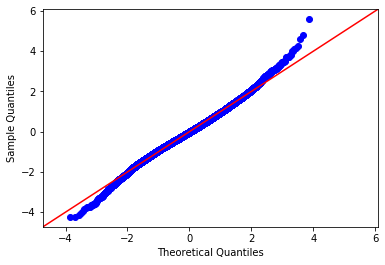

In [45]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

[('F statistic', 1.0191094345597624), ('p-value', 0.191186022365446)]

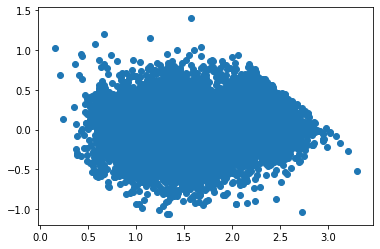

In [46]:
gq_test(reg_df5, model)

## Improvements

* Fixed residual normality issues in model.
* Fixed heteroskedasticity issues in model.
* Fixed multicollinearity issues in model

These problems are not completely solved, but the model is much improved in these regards.

## Compare vs Test Data

### Format Test Data

Transform Test data in same way as training, then apply same regression model

In [47]:
test_df = pd.read_csv('/Users/jamesfay/Desktop/FlatironWorkingDirectory/mod_2_project_v2/Data/Test_Table.csv')
test_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.head()

,id,bedrooms,bathrooms,sqft_living,log_lot,sqft_lot,floors,waterfront,condition,grade,zipcode,lat,long,yr_of_last_update,season_sold,below_ground_ratio,price_100k,long_lat,district,is_seattle
0,6802210090,3,2.25,1570,9.037177,8410,1.0,0.0,3,7,98022,47.1942,-121.990,1991,Summer,0.330508,2.5200,"(-121.99, 47.1942)",Enumclaw,0.0
1,3630120330,2,2.50,2290,8.162516,3507,2.0,0.0,3,9,98029,47.5545,-122.002,2005,Summer,0.000000,6.3000,"(-122.00200000000001, 47.5545)",Issaquah,0.0
2,2493200370,2,1.75,1550,8.356320,4257,1.0,0.0,3,7,98136,47.5274,-122.384,1953,Fall,0.867470,4.1500,"(-122.384, 47.5274)",Seattle,1.0
3,2843200085,3,1.00,1910,9.072227,8710,1.0,0.0,3,7,98168,47.5038,-122.300,1954,Winter,0.768519,2.6000,"(-122.3, 47.5038)",Highline,0.0
4,3300701365,3,1.75,1400,8.294050,4000,1.0,0.0,3,7,98117,47.6913,-122.381,1951,Spring,0.609195,5.1025,"(-122.381, 47.6913)",Seattle,1.0


In [48]:
test_df.shape

(4274, 20)

In [50]:
test_reg = test_df.drop(['zipcode', 'lat', 'long', 'id', 'long_lat', 'sqft_lot'], axis=1)

In [51]:
test_reg.loc[test_reg['district'].str.contains(top_5_str),'top_5_district'] = 1
test_reg['top_5_district'].fillna(0, inplace=True)
test_reg.head()

,bedrooms,bathrooms,sqft_living,log_lot,floors,waterfront,condition,grade,yr_of_last_update,season_sold,below_ground_ratio,price_100k,district,is_seattle,top_5_district
0,3,2.25,1570,9.037177,1.0,0.0,3,7,1991,Summer,0.330508,2.5200,Enumclaw,0.0,0.0
1,2,2.50,2290,8.162516,2.0,0.0,3,9,2005,Summer,0.000000,6.3000,Issaquah,0.0,1.0
2,2,1.75,1550,8.356320,1.0,0.0,3,7,1953,Fall,0.867470,4.1500,Seattle,1.0,0.0
3,3,1.00,1910,9.072227,1.0,0.0,3,7,1954,Winter,0.768519,2.6000,Highline,0.0,0.0
4,3,1.75,1400,8.294050,1.0,0.0,3,7,1951,Spring,0.609195,5.1025,Seattle,1.0,0.0


In [52]:
test_reg.drop(['district'], axis=1, inplace=True)

In [53]:
seasons = pd.get_dummies(test_reg['season_sold'], drop_first=True)
test_reg = pd.concat([test_reg, seasons], axis=1)

In [54]:
test_reg = test_reg.drop(['season_sold'], axis=1)

In [55]:
#Floors
floors = pd.get_dummies(test_reg['floors'], prefix='floors')
test_reg = pd.concat([test_reg, floors], axis=1)
test_reg.drop('floors', axis=1, inplace=True)

#Drop floor 2 to make it ref var
test_reg.drop('floors_2.0', axis=1, inplace=True)

#Rename floors so no decimal in column name
test_reg.rename(columns={'floors_1.0':'floors_1', 'floors_1.5':'floors_1h','floors_2.0':'floors_2','floors_2.5':'floors_2h','floors_3.0':'floors_3','floors_3.5':'floors_3h'}, inplace=True)

In [56]:
#Grade - Data in master table ranges from 3-13
grade = pd.get_dummies(test_reg['grade'], prefix='grade')
test_reg = pd.concat([test_reg, grade], axis=1)

#Drop Grade 7 (average grade) to make ref var
test_reg.drop('grade_7', axis=1, inplace=True)

test_reg.drop('grade', axis=1, inplace=True)

In [57]:
#Condition 
condition = pd.get_dummies(test_reg['condition'], prefix='cond')
test_reg = pd.concat([test_reg, condition], axis=1)

#Drop Condition 3 (average cond) to make ref var
test_reg.drop('cond_3', axis=1, inplace=True)

test_reg.drop('condition', axis=1, inplace=True)

In [58]:
test_reg['log_price'] = np.log(test_reg['price_100k'])
test_reg.drop('price_100k', axis=1, inplace=True)

In [59]:
test_reg.drop(['yr_of_last_update', 'below_ground_ratio'], axis=1)

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,is_seattle,top_5_district,Spring,Summer,Winter,...,grade_8,grade_9,grade_10,grade_11,grade_12,cond_1,cond_2,cond_4,cond_5,log_price
0,3,2.25,1570,9.037177,0.0,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.924259
1,2,2.50,2290,8.162516,0.0,0.0,1.0,0,1,0,...,0,1,0,0,0,0,0,0,0,1.840550
2,2,1.75,1550,8.356320,0.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.423108
3,3,1.00,1910,9.072227,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.955511
4,3,1.75,1400,8.294050,0.0,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.629731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,4,1.75,1240,8.418919,0.0,1.0,0.0,0,1,0,...,0,0,0,0,0,0,0,1,0,1.648659
4270,4,2.50,2800,8.827615,0.0,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,1,0,1.294727
4271,3,1.00,1340,12.634108,0.0,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.741937
4272,3,2.25,1440,8.157084,0.0,0.0,1.0,0,1,0,...,0,0,0,0,0,0,0,1,0,1.142629


In [60]:
test_reg.drop(['bathrooms', 'below_ground_ratio'], axis=1, inplace=True)

In [61]:
#Adjust so sqft has linear relationship with log_price
test_reg['log_living'] = np.log(test_reg['sqft_living'])

In [62]:
#Drop bedrooms to solve multicollinearity
test_reg.drop(['bedrooms', 'sqft_living'], axis=1, inplace=True)

In [63]:
test_reg.head()

,log_lot,waterfront,yr_of_last_update,is_seattle,top_5_district,Spring,Summer,Winter,floors_1,floors_1h,...,grade_9,grade_10,grade_11,grade_12,cond_1,cond_2,cond_4,cond_5,log_price,log_living
0,9.037177,0.0,1991,0.0,0.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0.924259,7.358831
1,8.162516,0.0,2005,0.0,1.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1.840550,7.736307
2,8.356320,0.0,1953,1.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1.423108,7.346010
3,9.072227,0.0,1954,0.0,0.0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0.955511,7.554859
4,8.294050,0.0,1951,1.0,0.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1.629731,7.244228


In [64]:
test_reg.shape

(4274, 27)

In [65]:
reg_df5.shape

(17094, 29)

### Apply Final Model to Test Data

In [66]:
outcome_t = 'log_price'
predictors_t = test_reg.drop('log_price', axis=1)
pred_sum_t = '+'.join(predictors_t.columns)
formula_t = outcome_t + '~' + pred_sum_t
model_t = ols(formula=formula_t, data=test_reg).fit()
model_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     454.2
Date:                Mon, 13 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:21:03   Log-Likelihood:                -177.16
No. Observations:                4274   AIC:                             408.3
Df Residuals:                    4247   BIC:                             580.1
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5956      0.443      1.345      0.179      -0.273       1.464
log_lot               0.0415      0.006      7.193      0.000       0.030       0.053
waterfront            0.7215      0.066     10.964      0.000       0.593       0.851
yr_of_last_update    -0.0017      0.000     -7.966      0.000      -0.002      -0.001
is_seattle            0.4838      0.012     41.159      0.000       0.461       0.507
top_5_district        0.4154      0.010     40.605      0.000       0.395       0.435
Spring                0.0578      0.011      5.411      0.000       0.037       0.079
Summer                0.0075      0.011      0.700      0.484      -0.014       0.029
Winter                0.0154      0.012      1.238      0.216      -0.009       0.040
floors_1             -0.0075      0.011     -0.669      0.504      -0.029       0.014
floors_1h             0.0071      0.018      0.401      0.688      -0.028       0.042
floors_2h             0.0743      0.046      1.623      0.105      -0.015       0.164
floors_3              0.0108      0.025      0.429      0.668      -0.039       0.060
floors_3h             0.0347      0.147      0.236      0.813      -0.253       0.322
grade_4              -0.0973      0.115     -0.848      0.396      -0.322       0.128
grade_5              -0.1703      0.042     -4.049      0.000      -0.253      -0.088
grade_6              -0.1418      0.015     -9.217      0.000      -0.172      -0.112
grade_8               0.1829      0.011     17.143      0.000       0.162       0.204
grade_9               0.3826      0.016     24.626      0.000       0.352       0.413
grade_10              0.5085      0.024     21.601      0.000       0.462       0.555
grade_11              0.5517      0.035     15.734      0.000       0.483       0.620
grade_12              0.5895      0.092      6.394      0.000       0.409       0.770
cond_1               -0.3646      0.128     -2.856      0.004      -0.615      -0.114
cond_2               -0.1926      0.042     -4.582      0.000      -0.275      -0.110
cond_4                0.0390      0.010      3.907      0.000       0.019       0.059
cond_5                0.1136      0.016      7.220      0.000       0.083       0.144
log_living            0.4645      0.015     30.761      0.000       0.435       0.494
==============================================================================
Omnibus:                       70.096   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.062
Skew:                          -0.012   Prob(JB):                     1.73e-30
Kurtosis:                       3.877   Cond. No.                     2.26e+05
==============================================================================

Warnings:
[1] Standard Error

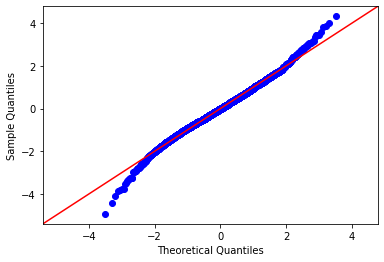

In [67]:
#Normality check for residuals with QQ plot
resid1_t = model_t.resid
fig_t = sm.graphics.qqplot(resid1_t, dist=stats.norm, line='45', fit=True)

Not perfect, but fairly normal.  Drift in bottom left could warrant further investigation.

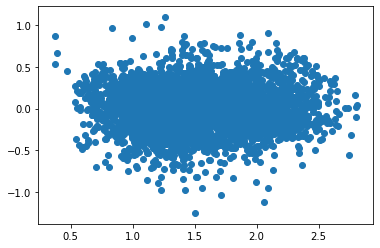

In [68]:
#Graph heteroskedasticity
pred_val_t = model_t.fittedvalues.copy()
residual_t = model_t.resid
plt.scatter(pred_val_t, residual_t)

The assumption of homoscedasticity is satisfied.

The model performs about as well on test data as it did on the training data, indicating that the model is effective and can be generalized to data outside of just the training dataset.  